In [1]:
import random
import pickle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import clip
import torch.nn.functional as F
import csv

In [2]:
class CustomCIFAR100Dataset(Dataset):
    cifar100_dataset = None

    @classmethod
    def load_dataset(cls, root="./data/cifar100", train=True, download=True, transform=None):
        cls.cifar100_dataset = datasets.CIFAR100(root, train=train, download=download, transform=transform)

    def __init__(self):
        if CustomCIFAR100Dataset.cifar100_dataset is None:
            raise RuntimeError("Dataset not loaded. Call load_dataset() before creating instances of this class.")

    def __getitem__(self, index):
        data_point, label = CustomCIFAR100Dataset.cifar100_dataset[index]
        return index, (data_point, label)

    def __len__(self):
        return len(CustomCIFAR100Dataset.cifar100_dataset)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

crop = transforms.RandomCrop(32, padding=4)
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

preprocess_rand = transforms.Compose([crop, transforms.RandomHorizontalFlip(), preprocess])
CustomCIFAR100Dataset.load_dataset(transform=preprocess_rand)
custom_cifar100_dataset = CustomCIFAR100Dataset()

Files already downloaded and verified


In [4]:
batch_size = 256
print('Data Loader')
data_loader = torch.utils.data.DataLoader(dataset=custom_cifar100_dataset, batch_size=batch_size, shuffle=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

record = [[] for _ in range(100)]

for batch_idx, (index, (data, labels)) in enumerate(data_loader):
    data = data.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        extracted_feature = model.encode_image(data)
    for i in range(extracted_feature.shape[0]):
        record[labels[i]].append({'feature': extracted_feature[i].detach().cpu(), 'index': index[i]})

Data Loader


In [7]:
total_len = sum([len(a) for a in record])
origin_trans = torch.zeros(total_len, record[0][0]['feature'].shape[0])
origin_label = torch.zeros(total_len).long()
index_rec = np.zeros(total_len, dtype=int)
cnt, lb = 0, 0
for item in record:
    for i in item:
        origin_trans[cnt] = i['feature']
        origin_label[cnt] = lb
        index_rec[cnt] = i['index']
        cnt += 1
    lb += 1
labels = np.array(origin_label)

C:\Users\maoda\AppData\Local\Temp\ipykernel_20996\3013186166.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tx[indices], ty[indices], c=colors[i], label=f" {class_name[i]}")


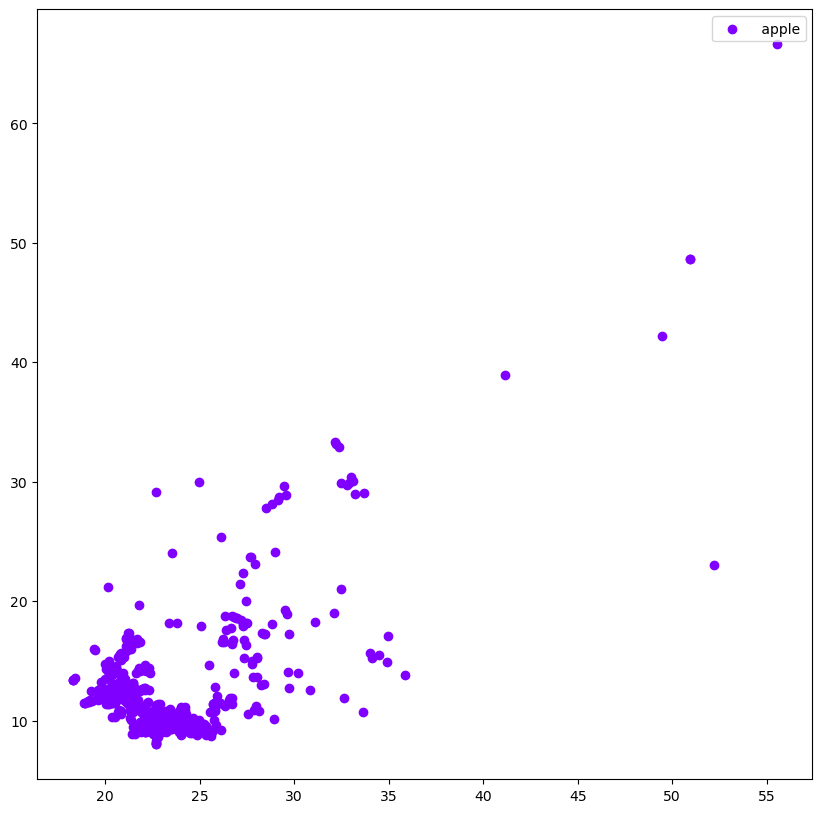

In [8]:
with open("labels.pkl", "wb") as f:
    pickle.dump(labels, f)
# Print shape of array
# tsne = TSNE(n_components=2).fit_transform(origin_trans)
tsne_path_name = "tsne_extracted.pkl"
with open(tsne_path_name, "rb") as f:
    tsne = pickle.load(f)


def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return (starts_from_zero / value_range) * 100


# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

fig, ax = plt.subplots(figsize=(10, 10))

# for every class, we'll add a scatter plot separately


class_name = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
              'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'unknown']
colors = plt.cm.rainbow(np.linspace(0, 1, len(class_name)))
num_classes = 21
# area = np.ones((128,), dtype=int)
for i in range(1):
    indices = np.where(labels == i)[0]
    # colors = np.array(i, dtype=np.float) / 255
    if i == 0:
        ax.scatter(tx[indices], ty[indices], c=colors[i], label=f" {class_name[i]}")
    else:

        ax.scatter(tx[indices], ty[indices], s=10 * 10, c=colors[i], alpha=0.5, label=f" {class_name[i]}")

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()